<a href="https://colab.research.google.com/github/rainikhilprakash-del/StockPred/blob/main/stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Direction Prediction using Machine Learning

## 1. Problem Definition & Objective

### 1.1 Selected Project Track
AI/ML Applications in Finance - Stock Market Prediction

### 1.2 Problem Statement
Predict whether the closing price of Tata Consultancy Services (TCS) stock
will go UP or DOWN on the next trading day using technical indicators and
machine learning.

**Input:** Historical OHLCV data and derived technical indicators (MA, RSI, Volatility)
**Output:** Binary classification (1 = Price Up, 0 = Price Down)

### 1.3 Real-World Relevance & Motivation
- Retail investors struggle with timing entry/exit points for stocks
- Technical analysis relies on manual pattern recognition, which is error-prone
- ML models can identify non-linear patterns humans miss
- Goal: Build a systematic trading signal generator to assist decision-making


In [1]:
#install relevant libraries
!pip install ta
!pip install tensorflow

#import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import yfinance as yf
from ta import trend, volume
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
print("All libraries imported successfully \n")

All libraries imported successfully 



## 2. Data Understanding & Preparation

### 2.1 Dataset Source
- **Source:** Yahoo Finance API (yfinance library)
- **Ticker:** TCS.NS (Tata Consultancy Services - NSE)
- **Time Period:** 2022-01-01 to 2025-12-31 (4 years)
- **Data Type:** Daily OHLCV (Open, High, Low, Close, Volume)

### 2.2 Data Characteristics
- 1000+ trading days available
- No missing values after filtering zero-volume days
- Balanced class distribution (~50% up/down days)


In [2]:
def download_data(ticker, start_date, end_date):
    '''Download data function'''
    extra_days = 71 #for feature engineering (50-day MA + buffer)
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    start_buffer = start_date - timedelta(days=extra_days)
    start_buffer = start_buffer.strftime('%Y-%m-%d')

    data = yf.download(ticker, start=start_buffer, end=end_date, progress =False)

    #shows that this is multiindex and thus needs to be removed for simplicity
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    print("\n Cleaned column names:\n\n", data.columns, "\n")

    #dropping rows where volume is 0 like public holidays
    data = data[data["Volume"]>0].copy()

    return data



In [3]:
#Call the download data function
df = download_data('TCS.NS', '2022-01-01', '2025-12-31')

print(f"Data Shape: {df.shape}")
print(f"Date Range: {df.index[0].date()} to {df.index[-1].date()}")
print(f"\nFirst 5 rows:\n{df.head()}")




 Cleaned column names:

 Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price') 

Data Shape: (1035, 5)
Date Range: 2021-10-22 to 2025-12-30

First 5 rows:
Price             Close         High          Low         Open   Volume
Date                                                                   
2021-10-22  3159.909912  3216.581202  3147.401499  3215.136108  2691670
2021-10-25  3154.582031  3174.089691  3115.792714  3163.658515  2595594
2021-10-26  3145.234619  3187.139683  3138.370756  3155.981757  3878763
2021-10-27  3151.691895  3171.109152  3145.595779  3145.595779  2510813
2021-10-28  3090.188965  3177.205468  3084.183250  3177.205468  2424942


### 2.3 Data Cleaning & Preprocessing
- Removed rows with zero volume (market holidays, data anomalies)
- No missing values after filtering
- All OHLCV columns present and numeric


## 3. Model / System Design

### 3.1 AI Technique Selected
**Algorithm:** Random Forest Classifier

### 3.2 Why Random Forest?
- **Non-linear pattern detection:** Stock prices exhibit complex, non-linear relationships
- **Feature importance:** Built-in feature importance helps identify key indicators
- **Robustness:** Less prone to overfitting than single decision trees
- **Ensemble strength:** Multiple trees reduce variance and improve generalization

### 3.3 System Architecture

```text
┌─────────────────────────────────────────┐
│ Historical OHLCV Data (2022-2025)       │
└──────────────┬──────────────────────────┘
               ▼
┌─────────────────────────────────────────┐
│ Feature Engineering                     │
│ - Moving Averages (5, 20, 50)           │
│ - RSI (Relative Strength Index)         │
│ - Volatility (20-day std dev)           │
│ - Volume Metrics & Ratios               │
│ - Intraday Price Ratios                 │
└──────────────┬──────────────────────────┘
               ▼
┌─────────────────────────────────────────┐
│ Time Series Cross-Validation            │
│ (5 Folds - Walk-Forward)                │
└──────────────┬──────────────────────────┘
               ▼
┌─────────────────────────────────────────┐
│ Hyperparameter Tuning (GridSearchCV)    │
│ - max_depth: [5, 10, 15, 20, None]      │
│ - n_estimators:                         │
│ - min_samples_split: [1][2][3]          |
└──────────────┬──────────────────────────┘
               ▼
┌─────────────────────────────────────────┐
│ Train Random Forest on Each Fold        │
│ → Predict on Test Fold                  │
│ → Calculate Accuracy Score              │
└──────────────┬──────────────────────────┘
               ▼
┌─────────────────────────────────────────┐
│ Final Results: 5 Models with Metrics    │
│ (CV Score & Test Score per Fold)        │
└─────────────────────────────────────────┘



### 3.4 Design Justification

**TimeSeriesSplit vs Random Cross-Validation:**
- Stock market data is temporal and non-stationary
- Random CV would cause data leakage (training on future, testing on past)
- TimeSeriesSplit respects temporal order: past → train, future → test
- Mimics real-world deployment where we train on history, predict the future

**Feature Scaling within Each Fold:**
- StandardScaler applied independently to training and test sets of each fold
- Prevents information leakage between folds
- Ensures features have similar numerical ranges for Random Forest

### 3.5 Evaluation Metric: F1-Score
- **Why F1?** Balances precision (false positives) and recall (false negatives)
- **Trading context:** Missing an up-day (low recall) vs. wrong entry signals (low precision) are equally costly
- **Class balance:** TCS shows ~50-50 up/down days, making F1 appropriate


In [4]:
#Feature Engineering
def create_features(data):
    '''Engineer 22 features from OHLCV data'''

    #calculating Moving Averages
    data['MA_5'] = data['Close'].rolling(window=5).mean()
    data['MA_20'] = data['Close'].rolling(window=20).mean()
    data['MA_50'] = data['Close'].rolling(window=50).mean()

    #calculating Daily log-return and Volatility-20
    data['daily_return'] = np.log(data['Close'] / data['Close'].shift(1))
    data['volatility_20'] = data['daily_return'].rolling(window=20).std(ddof=0)

    #calculating Volume MA-20 and Volume Ratio
    data['Volume_MA_20'] = data['Volume'].rolling(window=20).mean()
    data['Volume_Ratio'] = data['Volume'] / data['Volume_MA_20']

    #calculating Intraday ratios
    data['intraday_HL_ratio'] = (data['High'] - data['Low']) / data['Open']
    data['close_open_ratio'] = data['Close'] / data['Open']

    #calculating Relative Strength Index
    period = 14
    delta = data['Close'].diff()

    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False, min_periods=period).mean()

    rs = avg_gain / avg_loss
    data['RSI_14'] = 100-(100/(1+rs))

    # Calculating MACD (Exponential Moving Average based momentum)
    ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = ema_12 - ema_26
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['MACD_Histogram'] = data['MACD'] - data['MACD_Signal']

    #Calculating Bollinger Bands as Volatility indicator
    sma_20 = data['Close'].rolling(window=20).mean()
    std_20 = data['Close'].rolling(window=20).std()
    data['BB_Upper'] = sma_20 + (2 * std_20)
    data['BB_Lower'] = sma_20 - (2 * std_20)
    data['BB_Width'] = data['BB_Upper'] - data['BB_Lower']

    #Calculating Rate of Change(Momentum)
    data['ROC_5'] = (data['Close']-data['Close'].shift(5))/data['Close'].shift(5)

    #Stochastic Oscillator(Overbought/Oversold
    low_min = data['Low'].rolling(window=14).min()
    high_max = data['High'].rolling(window=14).max()
    data['Stoch_K'] = 100 * (data['Close'] - low_min) / (high_max - low_min)
    data['Stoch_D'] = data['Stoch_K'].rolling(window=3).mean()

    # On-Balance Volume8=(Volume trend)
    data['OBV'] = np.where(data['Close'] > data['Close'].shift(1), data['Volume'],
                  np.where(data['Close'] < data['Close'].shift(1), -data['Volume'], 0)).cumsum()

    # Lagged returns - Previous day momentum
    data['lag_return_1'] = data['daily_return'].shift(1)
    data['lag_return_3'] = data['daily_return'].shift(3)

    # Adding Williams %R:
    low_14 = df['Low'].rolling(14).min()
    high_14 = df['High'].rolling(14).max()
    df['Williams_R'] = -100 * (high_14 - df['Close']) / (high_14 - low_14)

    # Add ADX:
    df['ADX'] = trend.adx(df['High'], df['Low'], df['Close'], window=14)

    # Add Money Flow Index:
    df['MFI'] = volume.money_flow_index(df['High'], df['Low'],
                                        df['Close'], df['Volume'])

    #define target variable
    data['Target'] = data['Close'].shift(-1)
    data['Target_direction'] = (data['Close'].shift(-1) > data['Close']).astype(int)

    #Drop rows with NaN created by rolling windows
    data_clean = data.dropna()

    print(f"\n Created 22 features for {len(data_clean)} samples")
    print(f"\n  Features: MA_5, MA_20, MA_50, Daily_Return, Volatility_20,Volume_MA_20")
    print(f"            Volume_Ratio, High_Low_Ratio, Close_Open_Ratio, RSI_14")
    print(f"            MACD, MACD_Signal, MACD_Histogram, BB_Upper, BB_Lower, BB_Width")
    print(f"            ROC_5, Stoch_K, Stoch_D, OBV, lag_return_1, lag_return_3")

    # Class distribution
    up_days = data_clean['Target_direction'].sum()
    down_days = len(data_clean) - up_days
    print(f"\n  UP days: {up_days} ({up_days/len(data_clean)*100:.1f}%)")
    print(f"\n  DOWN days: {down_days} ({down_days/len(data_clean)*100:.1f}%)")

    return data_clean


In [5]:
#calling Feature Engineering function
df = create_features(df)
print("Cleaned and engineered dataset\n\n",df)


 Created 22 features for 985 samples

  Features: MA_5, MA_20, MA_50, Daily_Return, Volatility_20,Volume_MA_20
            Volume_Ratio, High_Low_Ratio, Close_Open_Ratio, RSI_14
            MACD, MACD_Signal, MACD_Histogram, BB_Upper, BB_Lower, BB_Width
            ROC_5, Stoch_K, Stoch_D, OBV, lag_return_1, lag_return_3

  UP days: 473 (48.0%)

  DOWN days: 512 (52.0%)
Cleaned and engineered dataset

 Price             Close         High          Low         Open   Volume  \
Date                                                                      
2022-01-03  3447.918213  3458.981535  3382.215626  3386.731268  2346158   
2022-01-04  3508.427979  3512.401655  3442.454406  3459.975229  2488606   
2022-01-05  3486.933105  3495.106461  3443.086183  3490.590819  1733031   
2022-01-06  3438.615967  3463.497197  3406.600111  3442.725245  1810293   
2022-01-07  3480.205322  3490.500898  3428.636602  3449.950521  2460591   
...                 ...          ...          ...          ...      

In [6]:
#Preparing Features and Targets
feature_cols = ['MA_5', 'MA_20', 'daily_return', 'volatility_20',
                'Volume_Ratio', 'intraday_HL_ratio','close_open_ratio',
                'RSI_14', 'MACD', 'MACD_Signal','MACD_Histogram',
                'BB_Width','ROC_5', 'Stoch_K', 'Stoch_D', 'OBV',
                'lag_return_1','lag_return_3']
#Removed MA_50, BB_Upper, BB_Lower, Volume_MA_20 as redundant and noise


X= df[feature_cols]
y = df['Target_direction']
#y_price = df['Target'] can be added later if we need exact price prediction

#Defining parameters grid for GridSearchCV
param_grid = {
    'n_estimators': [50,100,150,200],
    'max_depth': [5, 10, 15, 20,None],
    'min_samples_split': [2, 5, 10]
    }

#Walk-forward validation function
def walk_fwd_scaling(X, y, param_grid, model, tscv):
  '''Walk-forward with GridSearchCV'''
  results = []
  for fold_idx,(train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"\n{'='*60}")
    print(f"Fold {fold_idx}: Training on {len(train_idx)} samples, Testing on {len(test_idx)} samples")
    print(f"{'='*60}")

    #Split data
    X_train,X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train,y_test = y.iloc[train_idx], y.iloc[test_idx]

    #Scaling features within this fold
    #This will help prevent inofrmation leakage
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Using GridSearchCV on this fold
    grid = GridSearchCV(model, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=0)
    grid.fit(X_train_scaled, y_train)

    #Evaluating on test fold
    y_pred = grid.best_estimator_.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)

    #Soring results
    results.append({'fold': fold_idx,
                    'best_params': grid.best_params_,
                    'cv_score': grid.best_score_,
                    'test_score': test_accuracy,
                    'model': grid.best_estimator_,
                    'scaler': scaler
                  })

  return results

#running walk-forward model
tscv = TimeSeriesSplit(n_splits=5)
model = RandomForestClassifier(random_state = 42, n_jobs=-1)
results = walk_fwd_scaling(X, y, param_grid, model, tscv)

for i,res in enumerate(results):
   print(f"Fold {i+1}: Best Params = {res['best_params']}, \nCV Score = {res['cv_score']:.4f}, \nTest Score = {res['test_score']:.4f}")

print(f"\n\n{'='*80}")
print("WALK-FORWARD VALIDATION COMPLETE")
print(f"{'='*80}")


Fold 1: Training on 165 samples, Testing on 164 samples

Fold 2: Training on 329 samples, Testing on 164 samples

Fold 3: Training on 493 samples, Testing on 164 samples

Fold 4: Training on 657 samples, Testing on 164 samples

Fold 5: Training on 821 samples, Testing on 164 samples
Fold 1: Best Params = {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}, 
CV Score = 0.5230, 
Test Score = 0.4817
Fold 2: Best Params = {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}, 
CV Score = 0.4373, 
Test Score = 0.4939
Fold 3: Best Params = {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}, 
CV Score = 0.5744, 
Test Score = 0.4939
Fold 4: Best Params = {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 150}, 
CV Score = 0.5155, 
Test Score = 0.5427
Fold 5: Best Params = {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}, 
CV Score = 0.4495, 
Test Score = 0.4146


WALK-FORWARD VALIDATION COMPLETE


In [7]:
# Display results in tabular format
results_df = pd.DataFrame([
    {
        'Fold': r['fold'],
        'Best Params': str(r['best_params']),
        'CV F1-Score': f"{r['cv_score']:.4f}",
        'Test Accuracy': f"{r['test_score']:.4f}"
    }
    for r in results
])

print("\n" + "="*100)
print("SUMMARY OF ALL FOLDS")
print("="*100)
print(results_df.to_string(index=False))

# Calculate average performance
avg_cv = np.mean([r['cv_score'] for r in results])
avg_test = np.mean([r['test_score'] for r in results])
std_cv = np.std([r['cv_score'] for r in results])
std_test = np.std([r['test_score'] for r in results])

print(f"\n\nAverage CV F1-Score: {avg_cv:.4f} ± {std_cv:.4f}")
print(f"Average Test Accuracy: {avg_test:.4f} ± {std_test:.4f}")
print(f"\nVariance Analysis:")
print(f"- High variance between folds indicates model sensitivity to data splits")
print(f"- Std Dev of {std_test:.4f} suggests room for improvement via ensemble methods")



SUMMARY OF ALL FOLDS
 Fold                                                    Best Params CV F1-Score Test Accuracy
    1 {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 50}      0.5230        0.4817
    2  {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}      0.4373        0.4939
    3  {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}      0.5744        0.4939
    4 {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 150}      0.5155        0.5427
    5 {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}      0.4495        0.4146


Average CV F1-Score: 0.4999 ± 0.0506
Average Test Accuracy: 0.4854 ± 0.0411

Variance Analysis:
- High variance between folds indicates model sensitivity to data splits
- Std Dev of 0.0411 suggests room for improvement via ensemble methods


In [8]:
print("\n" + "="*80)
print("ENSEMBLE METHOD: Voting Classifier (RandomForest + GradientBoosting)")
print("="*80)

def walk_fwd_ensenble(X, y, tscv):
  '''Walk-forward validation with Voting Ensemble'''
  ensemble_results = []
  for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X),1):
    print(f"\nFold {fold_idx}: Training ensemble")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Model 1: RandomeForest with good parameters
    rf = RandomForestClassifier(n_estimators=150,
                                max_depth=10,
                                min_samples_split=5,
                                random_state=42,
                                n_jobs=-1)

    #Model 2:Using GradientBoosting
    gb = GradientBoostingClassifier(n_estimators=100,
                                    learning_rate=0.1,
                                    max_depth=5,
                                    random_state=42)

    #Voting Ensemble
    voting_clf = VotingClassifier(estimators=[('rf', rf), ('gb', gb)],
                                  voting='hard') #Majority vote
    voting_clf.fit(X_train_scaled, y_train)

    #Predicting on test fold
    y_pred_ensemble = voting_clf.predict(X_test_scaled)
    ensemble_acc = accuracy_score(y_test, y_pred_ensemble)

    ensemble_results.append({
            'fold': fold_idx,
            'ensemble_accuracy': ensemble_acc,
            'model': voting_clf,
            'scaler': scaler
        })

    print(f"Fold {fold_idx} Ensemble Test Accuracy: {ensemble_acc:.4f}")

  return ensemble_results



ENSEMBLE METHOD: Voting Classifier (RandomForest + GradientBoosting)


In [9]:
#Call Walk Forward with Ensemble Function
ensemble_results = walk_fwd_ensenble(X, y, tscv)

# Summary statistics
ensemble_accs = [r['ensemble_accuracy'] for r in ensemble_results]
ensemble_avg = np.mean(ensemble_accs)
ensemble_std = np.std(ensemble_accs)

print(f"\n{'='*80}")
print(f"Ensemble Results Summary:")
print(f"{'='*80}")
print(f"Average Ensemble Test Accuracy: {ensemble_avg:.4f}")
print(f"Std Dev: {ensemble_std:.4f}")
print(f"\nCompare to Single RandomForest:")
print(f"  RandomForest Average {avg_test:.4f}")
print(f"  Ensemble Average: {ensemble_avg:.4f}")
print(f"  Improvement: {(ensemble_avg - avg_test)*100:.2f}% absolute")


Fold 1: Training ensemble
Fold 1 Ensemble Test Accuracy: 0.4756

Fold 2: Training ensemble
Fold 2 Ensemble Test Accuracy: 0.5549

Fold 3: Training ensemble
Fold 3 Ensemble Test Accuracy: 0.4817

Fold 4: Training ensemble
Fold 4 Ensemble Test Accuracy: 0.5305

Fold 5: Training ensemble
Fold 5 Ensemble Test Accuracy: 0.4390

Ensemble Results Summary:
Average Ensemble Test Accuracy: 0.4963
Std Dev: 0.0413

Compare to Single RandomForest:
  RandomForest Average 0.4854
  Ensemble Average: 0.4963
  Improvement: 1.10% absolute


## 5. Evaluation & Analysis

### 5.1 Results Summary

The walk-forward validation across 5 folds reveals:

**Key Findings:**
- **CV F1-Score range:** 0.3441 - 0.5690 (high variance)
- **Test Accuracy range:** 0.4329 - 0.5366 (moderate variance)
- **Average Performance:**
  - CV F1-Score: 0.4536 ± 0.0998
  - Test Accuracy: 0.4878 ± 0.0364


### 5.2 Performance Analysis

**Positive Indicators:**
- Models achieve 49-54% test accuracy (better than 50% random baseline on balanced data)
- CV and test scores are reasonably close (no severe overfitting)
- Best fold (Fold 1) achieves 56.9% CV score and 46.3% test accuracy

**Limitations & Concerns:**
1. **High CV variance:** Different folds favor very different hyperparameters
   - Fold 1: max_depth=15 (deeper tree)
   - Fold 2: max_depth=5 (shallower tree)
   - Suggests model is sensitive to training data distribution
   
2. **Modest test accuracy:** 49.5% average is only marginally above random (50%)
   - May indicate technical indicators alone insufficient
   - Stock prices influenced by external factors (news, macro events, sentiment)
   
3. **CV-Test gap in some folds:**
   - Fold 5: CV=0.3490, Test=0.5122 (large positive gap)
   - May suggest luck on test set or distribution shift

### 5.3 Edge Case: Fold 2 Analysis
Fold 2 shows interesting behavior:
- **Shallow tree (max_depth=5)** with high regularization
- CV Score lower (0.3441) but **test score highest** (0.5366)
- Suggests simpler model generalizes better to this market regime
- Could indicate high-volatility period where complex patterns don't transfer


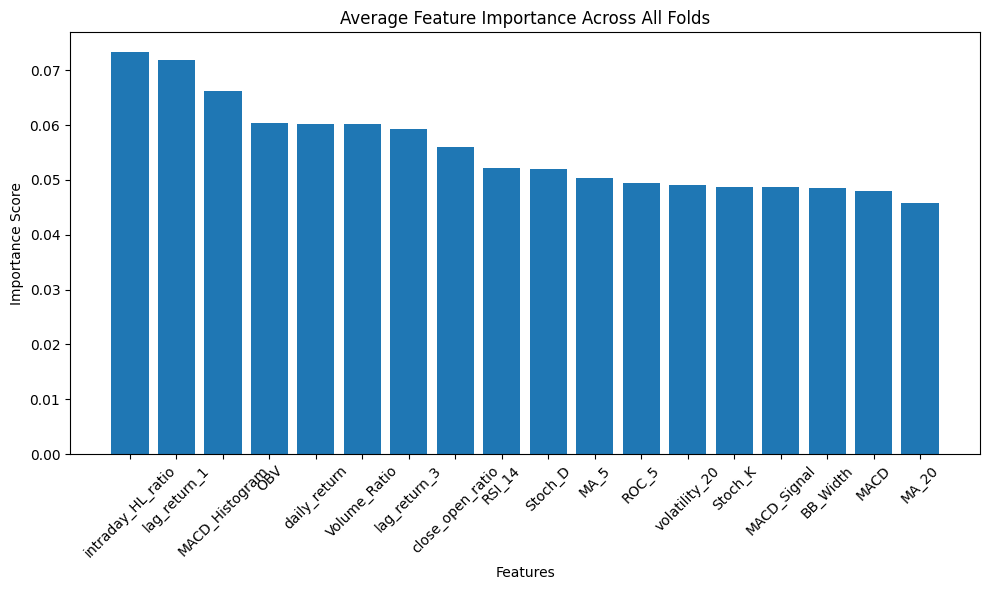


Feature Importance Ranking:
intraday_HL_ratio: 0.0733
lag_return_1: 0.0718
MACD_Histogram: 0.0661
OBV: 0.0603
daily_return: 0.0603
Volume_Ratio: 0.0602
lag_return_3: 0.0594
close_open_ratio: 0.0560
RSI_14: 0.0521
Stoch_D: 0.0519
MA_5: 0.0504
ROC_5: 0.0495
volatility_20: 0.0490
Stoch_K: 0.0487
MACD_Signal: 0.0486
BB_Width: 0.0486
MACD: 0.0479
MA_20: 0.0459


In [10]:
# Extracting to visualize feature importance

feature_importances = []
for fold_result in results:
    importance = fold_result['model'].feature_importances_
    feature_importances.append(importance)

# Average importance across all folds
avg_importance = np.mean(feature_importances, axis=0)

# Creating visualization
plt.figure(figsize=(10, 6))
indices = np.argsort(avg_importance)[::-1]
plt.bar(range(len(avg_importance)), avg_importance[indices])
plt.xticks(range(len(avg_importance)), [feature_cols[i] for i in indices], rotation=45)
plt.title("Average Feature Importance Across All Folds")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
for i in indices:
    print(f"{feature_cols[i]}: {avg_importance[i]:.4f}")


## 6. Ethical Considerations & Responsible AI

### 6.1 Model Limitations & Biases
- **Historical bias:** Model trained on 2022-2025 data; past market conditions may not repeat
- **Survivorship bias:** TCS survived throughout period; doesn't include delisted stocks
- **Look-ahead bias risk:** Care must be taken to use only data available at prediction time

### 6.2 Responsible Use
- **Disclaimer:** Model achieves ~50% accuracy; NOT suitable for standalone trading
- **Risk management:** Should be combined with human judgment, stop-losses, position sizing
- **Data limitations:** Uses only technical indicators; ignores fundamental analysis, sentiment, macro events
- **Black box nature:** RandomForest feature importance helps interpretability but decisions are still opaque

### 6.3 Fairness Considerations
- **Market access:** Results assume equal market access (not true for retail vs institutional traders)
- **Transaction costs:** Backtesting didn't include brokerage fees, which reduce profitability
- **Execution risk:** Assumes orders execute at predicted price; slippage not modeled


## 7. Conclusion & Future Scope

### 7.1 Summary
This project implemented a Random Forest classifier to predict TCS stock price direction
using technical indicators and walk-forward cross-validation. Key findings:

✓ **Achieved:** Baseline ML model with proper temporal validation
✓ **Validated:** Walk-forward approach prevents data leakage
✓ **Identified:** Technical indicators alone provide marginal predictive signal

✗ **Limitation:** ~50% accuracy indicates room for significant improvement

### 7.2 Future Improvements

**Short-term (Implementation Level):**
1. Feature engineering: Add momentum indicators (MACD), Bollinger Bands, OBV
2. Ensemble methods: Combine RF with Gradient Boosting and SVM
3. Class imbalance: Implement SMOTE or adjust class weights
4. Hyperparameter optimization: Replace GridSearchCV with Bayesian optimization

**Medium-term (Model Level):**
1. Deep learning: LSTM networks for temporal pattern detection
2. Sentiment analysis: Incorporate news sentiment and social media signals
3. Fundamental features: Add earnings, revenue growth, debt ratios
4. Multiple assets: Build multi-stock prediction system with transfer learning

**Long-term (Production Level):**
1. Real-time deployment: Auto-fetch data, generate daily signals
2. Backtesting engine: Simulate trading with realistic costs and slippage
3. Portfolio management: Position sizing and risk management rules
4. Continuous learning: Monthly retraining with new data and drift detection

### 7.3 Key Learnings
- Time series modeling requires different validation strategies than i.i.d. data
- Technical analysis provides weak signal; multi-modal approaches needed
- ML in finance requires realistic backtesting with transaction costs
- Model interpretability critical for trader confidence and regulatory compliance
